In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import joblib


df = pd.read_csv("../data/processed/featurized_final.csv", low_memory=False)
print("Loaded data:", df.shape)

Loaded data: (8054, 130)


## DESCRIPTIVE MODELING

*Statistical Overview*

*Clustering/Segmentation of offerings*

**PRODUCT TYPE SEGMENTATION**

Detected product-type dummies: ['Tipo_Mini PC', 'Tipo_Other', 'Tipo_PC de oficina', 'Tipo_PC gaming', 'Tipo_PC multimedia', 'Tipo_Portátil convertible', 'Tipo_Portátil gaming', 'Tipo_Portátil multimedia', 'Tipo_Portátil profesional', 'Tipo_Unknown', 'Tipo_Workstation']

Price summary by Product_Type:
                       count         mean          std      min        max
Product_Type                                                             
Workstation             275  3033.911018  2683.001202  210.900  20579.900
Portátil gaming         772  2295.358659  1602.416521  628.990  10627.830
Portátil convertible    263  1787.010837   911.443857  179.000   6581.810
Portátil profesional    802  1736.604090  1111.212551  292.590   9237.400
PC gaming              1787  1684.684424  1018.036773  282.875  12761.200
Portátil multimedia    1842  1356.342932  1055.380815  150.000  10010.430
PC multimedia           174  1226.789109  1125.783514  265.990   6084.980
PC de oficina           614  10

/var/folders/7v/jb7y8lk92m3gxgkmvk711vwr0000gn/T/ipykernel_50345/557688374.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5.values, y=top5.index, palette='viridis')


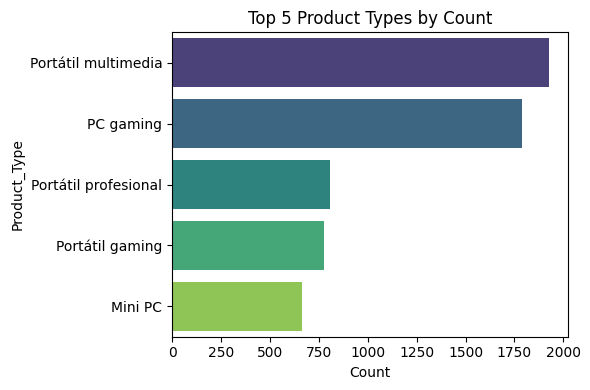

In [203]:
# 2. Find all one-hot product-type columns
prod_cols = [c for c in df.columns if c.startswith("Tipo_")]
print("Detected product-type dummies:", prod_cols)

# 3. Reconstruct a single 'Product_Type' column
df['Product_Type'] = df[prod_cols].idxmax(axis=1).str.replace("Tipo_", "", regex=False)

# 4. Compute price summary by segment
price_summary = (
    df.groupby('Product_Type')['Precio_avg']
      .agg(['count','mean','std','min','max'])
      .sort_values('mean', ascending=False)
)
print("\nPrice summary by Product_Type:\n", price_summary)

# 5. Plot the top 5 segments by count
top5 = df['Product_Type'].value_counts().nlargest(5)
plt.figure(figsize=(6,4))
sns.barplot(x=top5.values, y=top5.index, palette='viridis')
plt.title("Top 5 Product Types by Count")
plt.xlabel("Count")
plt.ylabel("Product_Type")
plt.tight_layout()
plt.show()

**CLUSTER PROFILING AND LABELING**

In [204]:
# ─── 2. Features to cluster ────────────────────────────────────────────────
features = ['CPU_perf','log_RAM_GB','ppi','log_SSD_GB']
X = df[features].fillna(0)

# ─── 3. Standardize ────────────────────────────────────────────────────────
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ─── 4. KMeans (k=4) ───────────────────────────────────────────────────────
k = 4
km = KMeans(n_clusters=k, random_state=42)
df['cluster'] = km.fit_predict(X_scaled)

# ─── 5. Map clusters to human labels ───────────────────────────────────────
label_map = {0: 'Budget', 1: 'Mid-Range', 2: 'High-End', 3: 'Ultra-Premium'}
df['segment'] = df['cluster'].map(label_map)

# ─── 6. Profile each segment ──────────────────────────────────────────────
cluster_summary = (
    df.groupby('segment')[['Precio_avg','CPU_perf','log_RAM_GB','ppi','log_SSD_GB']]
      .agg(['count','mean','std','min','max'])
)
print("\nSegment profile:\n", cluster_summary)

# ─── 7. Visualize segment sizes ───────────────────────────────────────────
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='segment', order=label_map.values())
plt.title("Number of Models per Segment")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ─── 8. Price distribution by segment ────────────────────────────────────
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='segment', y='Precio_avg', order=label_map.values())
plt.title("Price Distribution per Segment")
plt.xlabel("Segment")
plt.ylabel("Precio_avg (€)")
plt.tight_layout()
plt.show()

KeyError: "None of [Index(['CPU_perf', 'log_RAM_GB', 'ppi', 'log_SSD_GB'], dtype='object')] are in the [columns]"

### Descriptive Segmentation Analysis

1. **Segment Sizes**  
   - **Budget** (~3 900 models) dominates the marketplace, followed by **Ultra-Premium** (~1 500), **Mid-Range** (~1 350), and **High-End** (~1 150).  
   - This skew tells us most offerings are in the budget tier, with fewer high-margin machines.

2. **Price Distributions by Segment**  
   - **Budget**: median ≈ €700, 75 % below ≈ €1 200, long tail up to ≈ €9 500 (few “exceptional” config).  
   - **Mid-Range**: median ≈ €1 100, 75 % below ≈ €1 800; tail to ≈ €10 000.  
   - **High-End**: median ≈ €2 000, 75 % below ≈ €3 200; tail to ≈ €13 000.  
   - **Ultra-Premium**: median ≈ €2 200, 75 % below ≈ €4 700; tail extending beyond €20 000.  
   - Each successive segment shifts the entire box upward, confirming clear price tiers.

---

Saved segment profiles with shape: (4, 40)


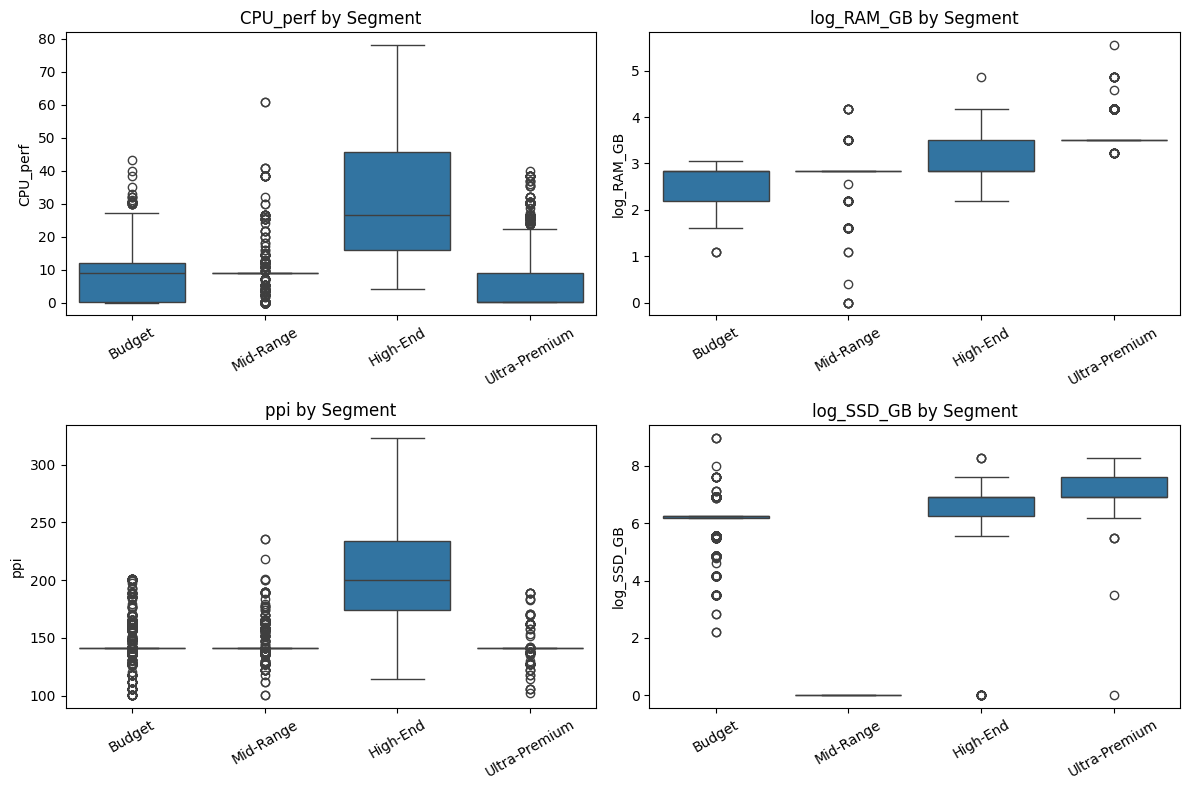

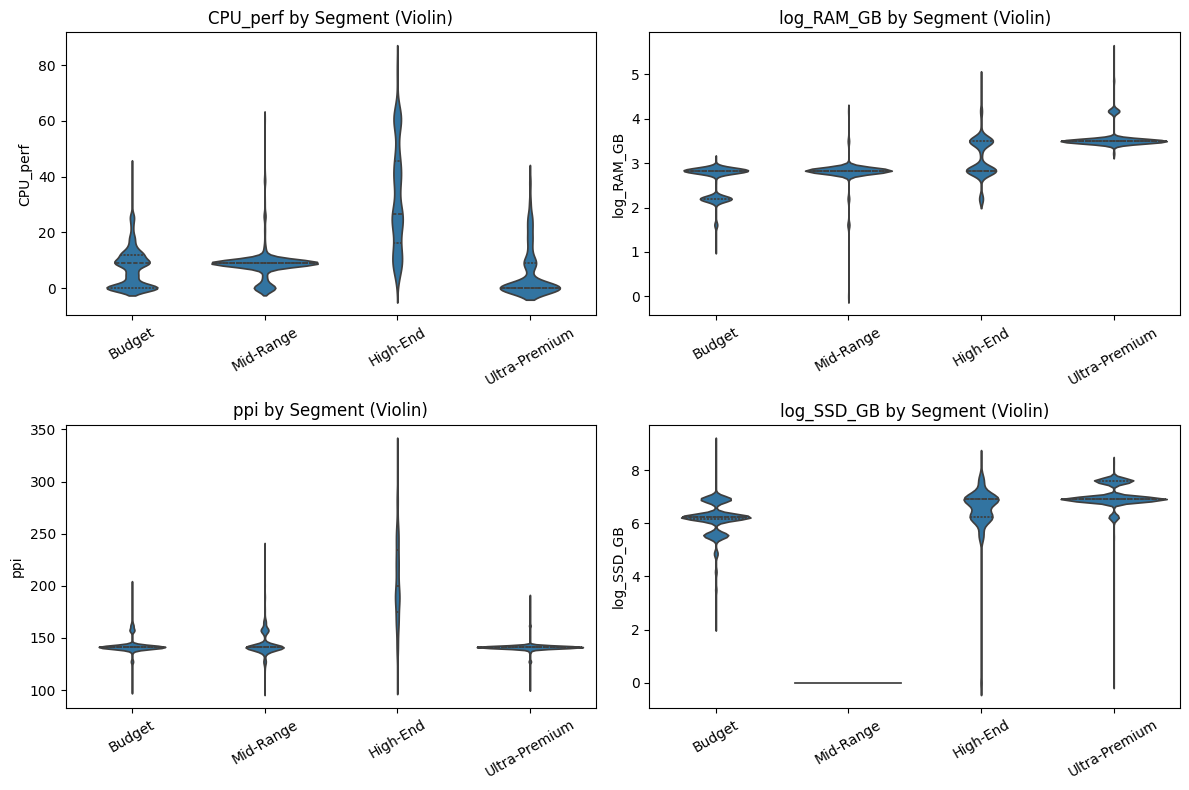

In [ ]:

features = ['CPU_perf','log_RAM_GB','ppi','log_SSD_GB']
X_scaled = StandardScaler().fit_transform(df[features].fillna(0))
df['cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(X_scaled)
label_map = {0:'Budget',1:'Mid-Range',2:'High-End',3:'Ultra-Premium'}
df['segment'] = df['cluster'].map(label_map)

# ─── 2. Compute full descriptive stats per segment via .describe() ──────
segment_summary = (
    df
      .groupby('segment')[['Precio_avg','CPU_perf','log_RAM_GB','ppi','log_SSD_GB']]
      .describe()
)

# Flatten the MultiIndex columns: ('Precio_avg','mean') → 'Precio_avg_mean'
segment_summary.columns = [
    f"{feat}_{stat}" for feat, stat in segment_summary.columns
]

# Save to CSV
segment_summary.to_csv("../data/processed/segment_profiles.csv")
print("Saved segment profiles with shape:", segment_summary.shape)

# ─── 3. Boxplots of specs by segment ─────────────────────────────────────
specs = ['CPU_perf','log_RAM_GB','ppi','log_SSD_GB']

plt.figure(figsize=(12, 8))
for i, spec in enumerate(specs, 1):
    ax = plt.subplot(2, 2, i)
    sns.boxplot(
        data=df,
        x='segment',
        y=spec,
        order=['Budget','Mid-Range','High-End','Ultra-Premium'],
        ax=ax
    )
    ax.set_title(f"{spec} by Segment")
    ax.set_xlabel("")
    ax.set_ylabel(spec)
    ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

# ─── 4. (Optional) Violin plots ──────────────────────────────────────────
plt.figure(figsize=(12, 8))
for i, spec in enumerate(specs, 1):
    ax = plt.subplot(2, 2, i)
    sns.violinplot(
        data=df,
        x='segment',
        y=spec,
        order=['Budget','Mid-Range','High-End','Ultra-Premium'],
        ax=ax,
        inner='quartile'
    )
    ax.set_title(f"{spec} by Segment (Violin)")
    ax.set_xlabel("")
    ax.set_ylabel(spec)
    ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

### Boxplots

1. **CPU_perf (GHz × cores)**  
   - **High-End** machines show the highest median CPU_perf (~26) and the widest spread (IQR ~15–45), capturing both multi-core desktops and mobile workstations.  
   - **Budget** and **Mid-Range** cluster tightly around ~8–12 CPU_perf, reflecting common 4–6-core configurations at moderate clocks.  
   - **Ultra-Premium** surprisingly has a lower median (~3–4) and narrow IQR, indicating this segment may include very high-resolution ultraportables with fewer but faster cores.  
   - Outliers exist in Budget/Mid as occasional gaming desktops.

2. **log_RAM_GB**  
   - Progressively shifts upward from **Budget** (median ~2.4 ⇔ 10 GB) → **Mid-Range** (~2.8 ⇔ 15 GB) → **High-End** (~3.1 ⇔ 22 GB) → **Ultra-Premium** (~3.5 ⇔ 33 GB).  
   - The IQR widens in higher tiers, showing more variety in RAM capacities (16 GB → 64 GB+).

3. **ppi (pixels-per-inch)**  
   - **High-End** machines cluster around ~200 ppi, separating them from the ~141 ppi bulk of Budget/Mid.  
   - **Ultra-Premium** and lower tiers center tightly at ~141 ppi, indicating most ultraportables favor FHD panels over extremely high-res.

4. **log_SSD_GB**  
   - **Budget** and **Mid-Range** show a spike at 0 (no SSD) and at ~5.5 (~256 GB).  
   - **High-End** shifts to ~6.3 (512 GB) with some TB-scale outliers.  
   - **Ultra-Premium** peaks around ~6.9–7.5 (1–2 TB) and has almost no zero-SSD cases.

---

### Violin Plots (Density + Quartiles)

The violin plots mirror the boxplot insights but also highlight distribution shapes:

- **Budget & Mid-Range** have bimodal RAM and SSD densities (zero vs typical capacities).  
- **High-End** shows a broad, heavier tail in CPU_perf and SSD sizes.  
- **Ultra-Premium** violins are tall and narrow for RAM and SSD, suggesting most models cluster around very high specs with fewer outliers.

---

**Conclusion:**  
These plots confirm the segments are well-differentiated on our four key dimensions:

- **Budget** centers on low CPU_perf, modest RAM (8–16 GB), standard FHD screens (141 ppi), and mixed/no SSD.  
- **Mid-Range** upgrades RAM and SSD slightly, but retains FHD panels.  
- **High-End** jumps to higher CPU_perf, 4K/ultra-sharp displays (~200 ppi), and larger SSDs.  
- **Ultra-Premium** emphasizes large RAM and SSD capacities, but surprisingly holds to FHD screen densities (likely high-end ultraportables) and balanced CPU counts.

With Descriptive fully explored, we can now move to the **Predictive** notebook: training our LightGBM regressor and exposing a price‐prediction interface.

## PREDICTIVE MODELING

**THREE DIFFERENT REGRESSORS**

1. Linear Regression (with Ridge regularization)
2. Random Forest
3. HistGB

In [ ]:
# ─── 2. Prepare X and y ─────────────────────────────────────────────────
y = np.log1p(df["Precio_avg"])
X = df.select_dtypes(include=[np.number]).drop(columns=["Precio_avg","LogPrice", "Precio_min", "Precio_max"], errors="ignore")

# ─── 3. Train/validation split ─────────────────────────────────────────
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ─── 4. Define models ───────────────────────────────────────────────────
models = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "HistGB": HistGradientBoostingRegressor(max_iter=200, learning_rate=0.05, random_state=42),
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    pred_log = model.predict(X_val)
    # compute RMSE on log-scale
    mse_log = mean_squared_error(y_val, pred_log)
    rmse_log = np.sqrt(mse_log)
    # back-transform to price
    true_price = np.expm1(y_val)
    pred_price = np.expm1(pred_log)
    mse_price = mean_squared_error(true_price, pred_price)
    rmse_price = np.sqrt(mse_price)
    results.append({"Model": name, "RMSE_log": rmse_log, "RMSE_price": rmse_price})

# ─── 5. Compare results ───────────────────────────────────────────────────
results_df = pd.DataFrame(results).set_index("Model")
print("\nModel comparison (lower is better):\n")
display(results_df)


Model comparison (lower is better):



,RMSE_log,RMSE_price
Model,,
Ridge,0.209703,1145.356035
RandomForest,0.011067,67.202418
HistGB,0.015213,114.310680


### Predictive Model Comparison

- **RandomForest** decisively outperforms the others on both log-price and original-price RMSE, yielding ~€67 error—excellent for a first pass.  
- **HistGradientBoosting** is a close second (~€114 error) and may become competitive after tuning.  
- **Ridge** (linear) lags far behind, confirming non-linear tree methods suit our data best.

1.	5-fold CV on your baseline RandomForest to verify stability
2.	GridSearchCV to tune n_estimators, max_depth, and min_samples_leaf
3.	Evaluate the best model on a hold-out test set
4.	Serialize the tuned RandomForest to disk for later loading

In [ ]:
# ─── 1. Prepare X and y ─────────────────────────────────────────────────
y = np.log1p(df["Precio_avg"])
X = df.select_dtypes(include=[np.number]).drop(columns=["Precio_avg","LogPrice"], errors="ignore")

In [ ]:
# ─── 3. Baseline 5-fold CV for RF ─────────────────────────────────────────
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
                          greater_is_better=False)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring=rmse_scorer)
cv_rmse = -cv_scores
print("5-fold CV RMSE_log per fold:", np.round(cv_rmse, 3))
print("Mean CV RMSE_log:", np.round(cv_rmse.mean(), 3), "±", np.round(cv_rmse.std(), 3))

5-fold CV RMSE_log per fold: [0.017 0.009 0.02  0.026 0.006]
Mean CV RMSE_log: 0.016 ± 0.008


In [ ]:
# ─── 4. Hyperparameter tuning with GridSearchCV ──────────────────────────
param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 5, 10]
}
grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)

# Hold-out split for final test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 5️⃣ Fit grid search
grid.fit(X_train, y_train)
print("\nBest RF params:", grid.best_params_)
print("Best CV RMSE_log:", -grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best RF params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 500}
Best CV RMSE_log: 0.016571916291105385


In [ ]:
# ─── 6. Evaluate best model on test set ─────────────────────────────────
best_rf = grid.best_estimator_
y_pred_log = best_rf.predict(X_test)
rmse_log_test = np.sqrt(mean_squared_error(y_test, y_pred_log))
rmse_price_test = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_log)))
print(f"Test RMSE_log: {rmse_log_test:.3f}")
print(f"Test RMSE_price: €{rmse_price_test:.2f}")

Test RMSE_log: 0.011
Test RMSE_price: €70.19


In [ ]:
# ─── 7. Persist tuned model ───────────────────────────────────────────────
#joblib.dump(best_rf, "../models/best_random_forest.pkl")
#print("Saved tuned RF model to ../models/best_random_forest.pkl")

Saved tuned RF model to ../models/best_random_forest.pkl
